In [43]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import corner
import emcee
import json

In [44]:
pfile = "../tests/files/real_mini_mcmc.json"
with open(pfile) as f:
    mcmc_dict = json.load(f)

labels = ["sfr_n", "alpha", "lmean", "lsigma", "lEmax", "lEmin", "gamma", "H0"]
filenames = ['../mcmc/BASE_lf0']
# filenames = ['../mcmc/BASE_Pn_Emin6']

# labels = ["sfr_n", "alpha", "lmean", "lsigma", "lEmax", "lEmin", "gamma", "DMhalo", "H0"]
# filenames = ['../mcmc/DMHALO6']

samples = []

for i, filename in enumerate(filenames):
    reader = emcee.backends.HDFBackend(filename + '.h5')
    samples.append(reader.get_chain())
    

In [45]:
# Make alpha negative
a=-1
for i, x in enumerate(labels):
    if x == r"$\alpha$":
        a = i

if a != -1:
    for sample in samples:
        sample[:,:,a] = -sample[:,:,a]    

In [46]:
# Make F linear
# a=-1
# for i, x in enumerate(labels):
#     if x == r"log$_{10}(F)$":
#         a = i

# if a != -1:
#     for sample in samples:
#         sample[:,:,a] = 10**sample[:,:,a]    

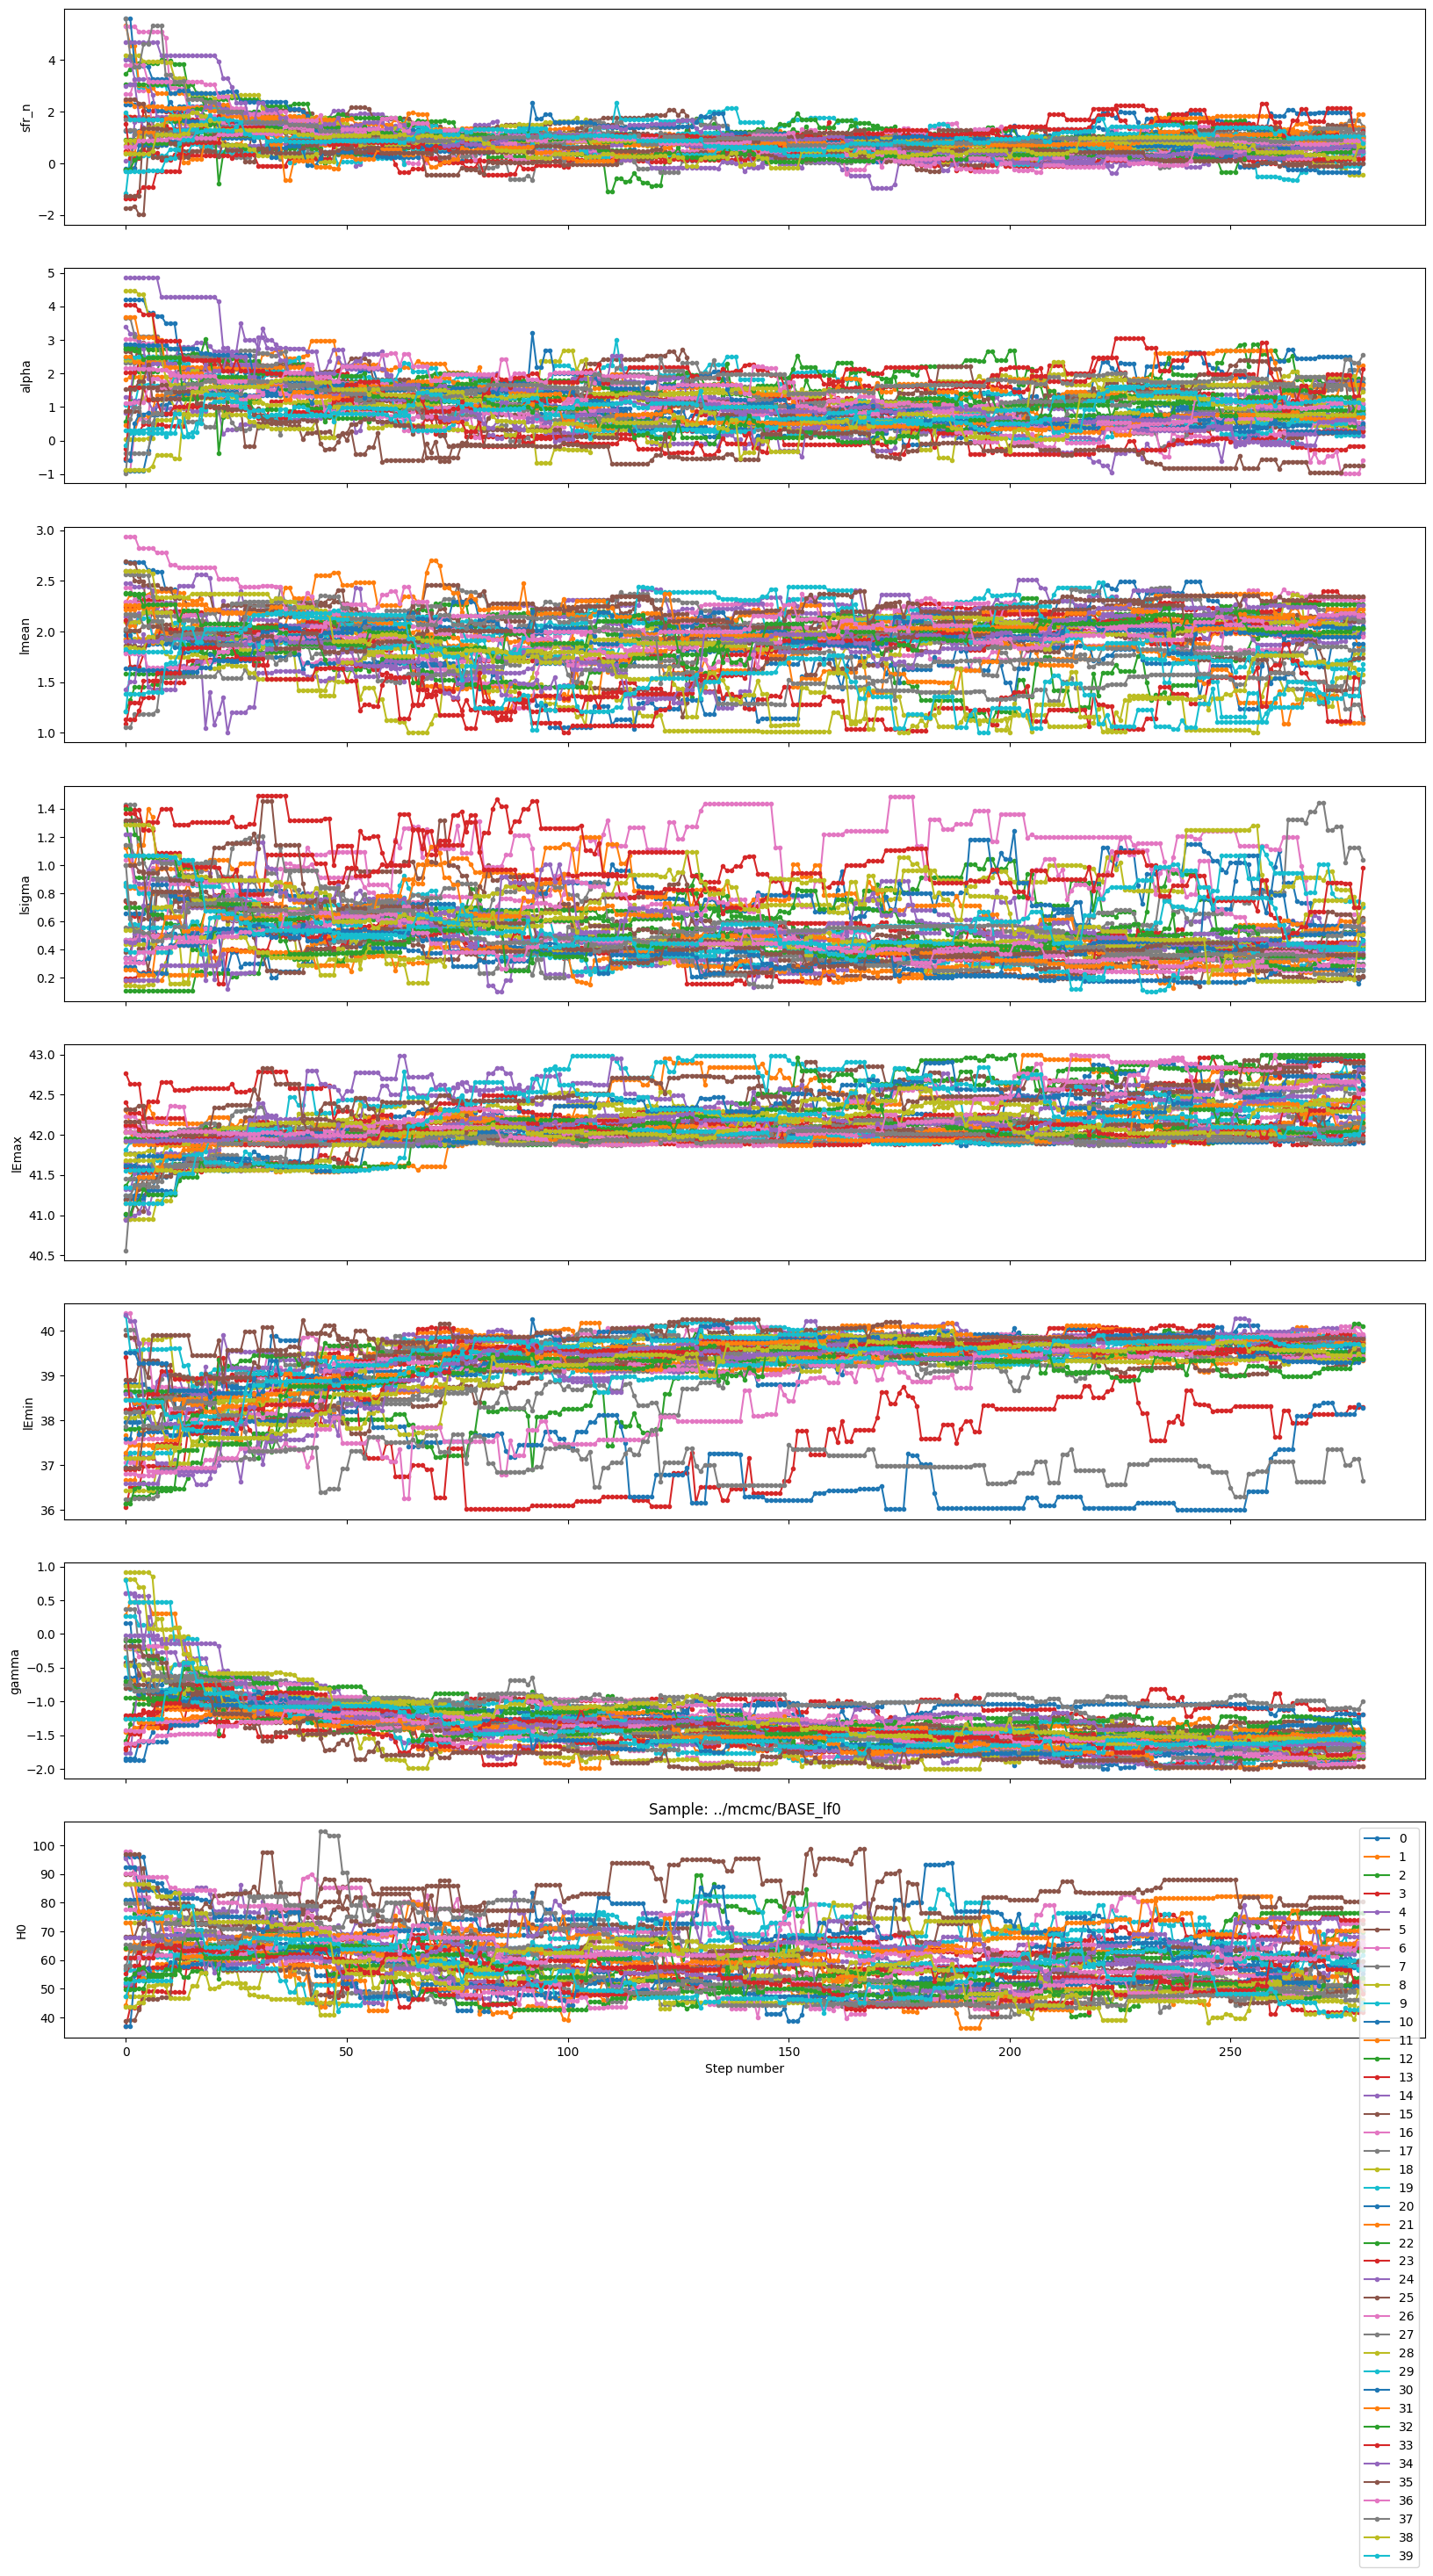

In [47]:
for j,sample in enumerate(samples):
    fig, axes = plt.subplots(sample.shape[2], 1, figsize=(20,30), sharex=True)
    plt.title("Sample: " + filenames[j])
    for i,ax in enumerate(axes):
        for k in range(sample.shape[1]):
            ax.plot(sample[:,k,i], '.-', label=str(k))

        ax.set_ylabel(labels[i])
    
    axes[-1].set_xlabel("Step number")
    axes[-1].legend()


In [48]:
# https://emcee.readthedocs.io/en/stable/tutorials/autocorr/#a-more-realistic-example
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm and acf[0] != 0:
        acf /= acf[0]

    return acf

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

def autocorr(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

# def autocorr_ml(y, thin=1, c=5.0):
#     # Compute the initial estimate of tau using the standard method
#     init = autocorr(y, c=c)
#     z = y[:, ::thin]
#     N = z.shape[1]

#     # Build the GP model
#     tau = max(1.0, init / thin)
#     kernel = terms.RealTerm(
#         np.log(0.9 * np.var(z)),
#         -np.log(tau),
#         bounds=[(-5.0, 5.0), (-np.log(N), 0.0)],
#     )
#     kernel += terms.RealTerm(
#         np.log(0.1 * np.var(z)),
#         -np.log(0.5 * tau),
#         bounds=[(-5.0, 5.0), (-np.log(N), 0.0)],
#     )
#     gp = celerite.GP(kernel, mean=np.mean(z))
#     gp.compute(np.arange(z.shape[1]))

    # # Define the objective
    # def nll(p):
    #     # Update the GP model
    #     gp.set_parameter_vector(p)

    #     # Loop over the chains and compute likelihoods
    #     v, g = zip(*(gp.grad_log_likelihood(z0, quiet=True) for z0 in z))

    #     # Combine the datasets
    #     return -np.sum(v), -np.sum(g, axis=0)

    # # Optimize the model
    # p0 = gp.get_parameter_vector()
    # bounds = gp.get_parameter_bounds()
    # soln = minimize(nll, p0, jac=True, bounds=bounds)
    # gp.set_parameter_vector(soln.x)

    # # Compute the maximum likelihood tau
    # a, c = kernel.coefficients[:2]
    # tau = thin * 2 * np.sum(a / c) / np.sum(a)
    # return tau

In [49]:
# Reject walkers with bad autocorrelation values
def auto_corr_rej(samples, burnin=0):
    good_samples = []

    # Loop through each sample and generate a list of good walkers and bad walkers
    for j,sample in enumerate(samples): 
        # burnin=200
        good_walkers = []
        bad_walkers = []


        # for i in range(sample.shape[1]):
        #     # if np.all(sample[burnin:burnin+30,i,0] == sample[burnin,i,0]):
        #     if ( np.std(sample[burnin:burnin+30,i,0] ) )
        #         bad_walkers.append(i)
        #     else:
        #         good_walkers.append(i)

        # Loop through each walker in the current sample
        for i in range(sample.shape[1]):
            bad = False

            # Loop through each parameter for the walker
            for k in range(sample.shape[2]):

                # If any of the parameters have a bad autocorrelation function then set as a bad walker
                acf = autocorr_func_1d(sample[burnin:,i,k], norm=False)
                if np.max(acf) < 1e-10:
                    bad = True
                    break

            if bad:
                bad_walkers.append(i)
            else:
                good_walkers.append(i)
            
            # fig = plt.figure()
            # plt.title(str(j) + ", " + str(i))
            # ax = fig.add_subplot(1,1,1)
            # ax.plot(acf)

        print("Discarded walkers for sample " + str(j) + ": " + str(bad_walkers))

        # Add the new sample with the bad walkers discarded to the good_samples list
        good_samples.append(sample[burnin:,good_walkers,:])

    return good_samples

# Reject walkers with small standard deviations
def std_rej(samples, burnin=0):
    good_samples = []

    if not type(burnin) == list:
        burnin = [burnin for i in range(len(samples))]

    # Loop through each sample
    for i, sample in enumerate(samples):
        bad_walkers = []
        good_walkers = []

        # For each parameter
        for k in range(sample.shape[2]):
            sd = []

            # Loop through every walker and get a list of the standard deviations
            for j in range(sample.shape[1]):
                sd.append(np.std(sample[burnin[i]:burnin[i]+100,j,k]))
            
            # Normalise standard deviation
            sd = sd / np.max(sd)

            # Flag any walkers with standard deviations less than 1e-2
            # bad_walkers = np.flatnonzero(sd < 1e-2)
            # temp = []
            for m in range(len(sd)):
                if sd[m] < 1e-2:
                    bad_walkers.append(m)
        
        # bad_walkers.append(33)
        bad_walkers = np.unique(np.array(bad_walkers))

        print("Discarded walkers for sample " + str(i) + ": " + str(bad_walkers))
        for l in range(sample.shape[1]):
            if l not in bad_walkers:
                good_walkers.append(l)

        # Add the new sample with the bad walkers discarded to the good_samples list
        good_samples.append(sample[burnin[i]:,good_walkers,:])
    
    return good_samples

In [50]:
good_samples = std_rej(samples, burnin=0)
# good_samples = samples
# _ = auto_corr_rej(samples, burnin=0)

Discarded walkers for sample 0: []


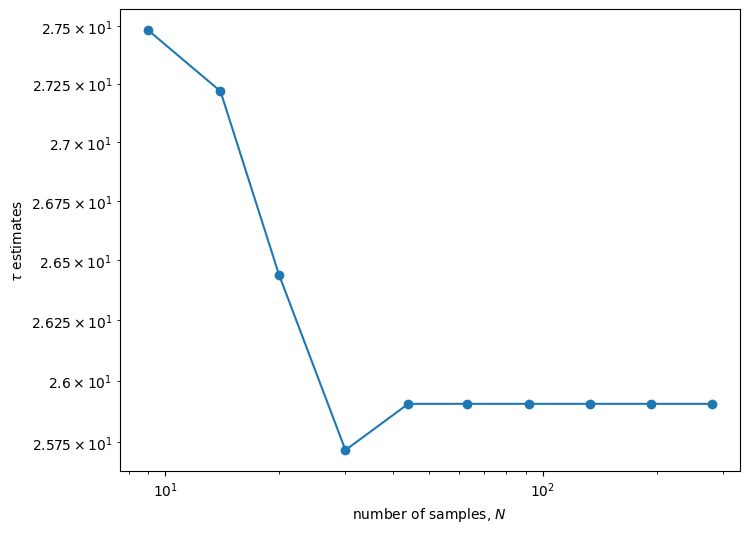

In [51]:
burnin = []
for sample in good_samples:
    # Compute the estimators for a few different chain lengths
    N = np.exp(np.linspace(np.log(10), np.log(sample.shape[0]), 10)).astype(int)
    new = np.empty(len(N))
    for i, n in enumerate(N):
        new[i] = autocorr(sample[:, :n, 0].T)

    # Plot the comparisons
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.loglog(N, new, "o-", label="new")
    ylim = ax.get_ylim()
    ax.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
    ax.set_ylim(ylim)
    ax.set_xlabel("number of samples, $N$")
    ax.set_ylabel(r"$\tau$ estimates")
    # ax.legend(fontsize=14);

    burnin.append(int(1.5*new[-1]))

In [52]:
# for j,sample in enumerate(good_samples):
#     fig, axes = plt.subplots(sample.shape[2], 1, figsize=(20,30), sharex=True)
#     plt.title("Sample: " + filenames[j])
#     for i,ax in enumerate(axes):
#         for k in range(sample.shape[1]):
#             ax.plot(sample[burnin[j]:,k,i], '.-', label=str(k))

#         ax.set_ylabel(labels[i])
    
#     axes[-1].set_xlabel("Step number")
#     axes[-1].legend()


In [53]:
# Enforce more restrictive priors on a parameter
def change_priors(sample, param_num, max=np.inf, min=-np.inf):

    condition = np.logical_and(sample[:,param_num] > min, sample[:,param_num] < max)
    good_idxs = np.flatnonzero(condition)

    return sample[good_idxs, :]

In [54]:
# Get the final sample without burnin and without bad walkers
final_sample = [[] for i in range(samples[0].shape[2])]

print(burnin)
burnin = (np.ones(len(good_samples)) * 150).astype(int)
print(burnin)

for j,sample in enumerate(good_samples):
    for i in range(sample.shape[2]):
        final_sample[i].append(sample[burnin[j]:,:,i].flatten())
final_sample = np.array([np.hstack(final_sample[i]) for i in range(len(final_sample))]).T

# final_sample = change_priors(final_sample, 5, min=38)
# final_sample = change_priors(final_sample, 7, max=110.0)
# final_sample = change_priors(final_sample, 9, max=80.0)
# final_sample = change_priors(final_sample, 1, max=1.0, min=-3.5)

print(final_sample.shape)


[38]
[50]
(9240, 8)


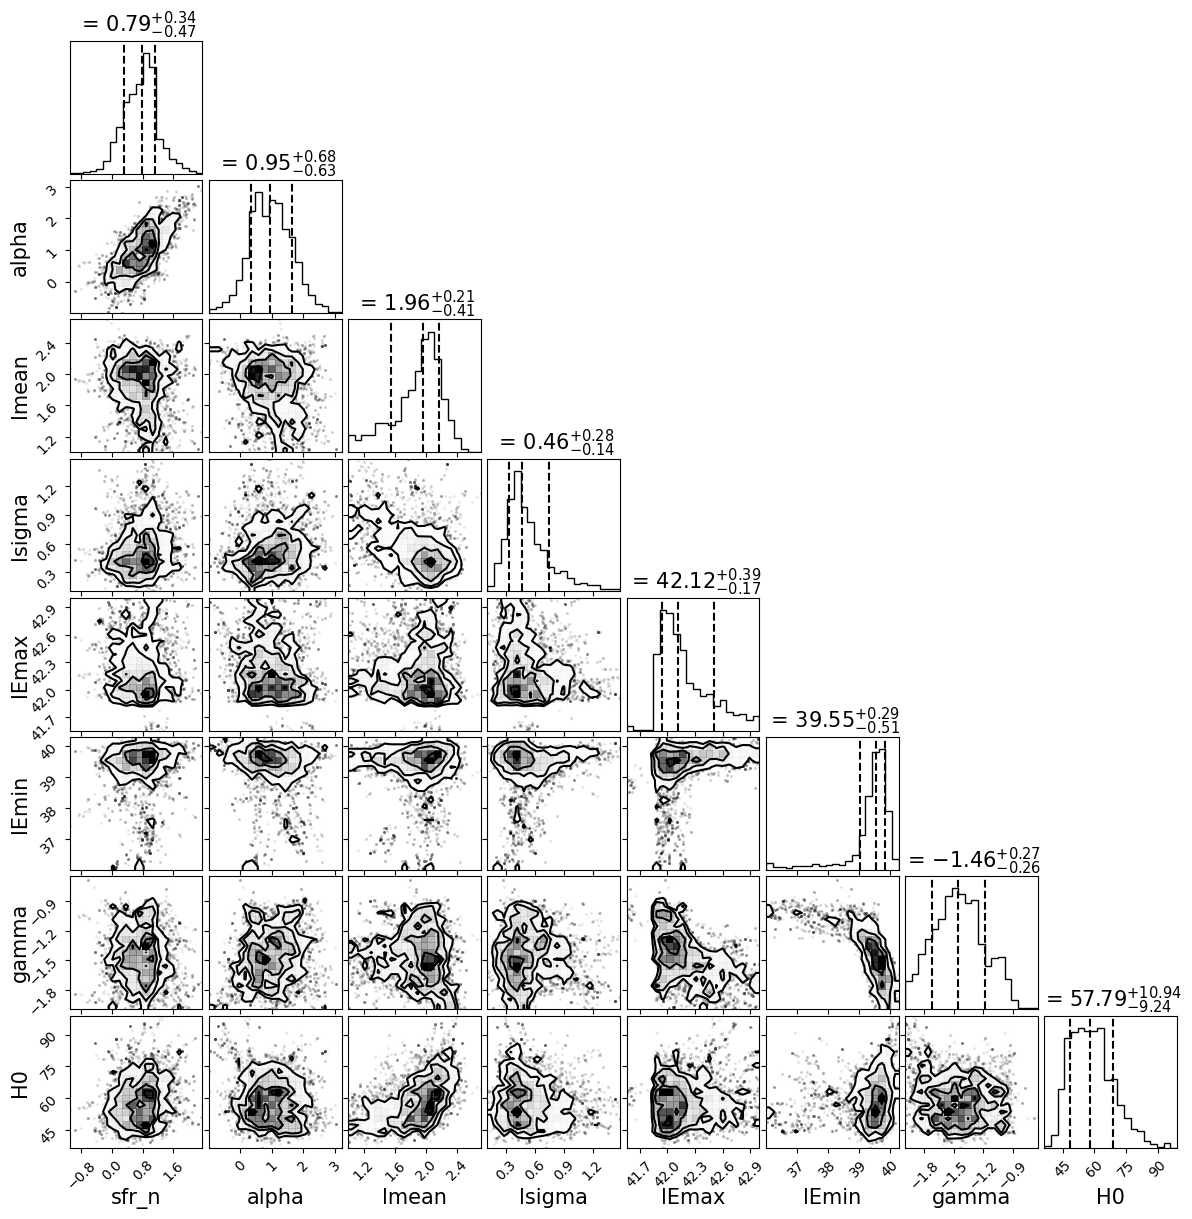

In [55]:
fig = plt.figure(figsize=(12,12))

titles = ['' for i in range(final_sample.shape[1])]
corner.corner(final_sample,labels=labels, show_titles=True, titles=titles, fig=fig,title_kwargs={"fontsize": 15},label_kwargs={"fontsize": 15}, quantiles=[0.16,0.5,0.84]);

sfr_n: 0.7898993307181696 (-0.47421767028432904/+0.33509929061604127)
alpha: 0.9549069713333098 (-0.6281110822449749/+0.6819196220175192)
lmean: 1.9572962246840238 (-0.4096260666871514/+0.20727725857279644)
lsigma: 0.46226542485137934 (-0.135143177366833/+0.2802024544728047)
lEmax: 42.11502103434281 (-0.1721967278538159/+0.3889972444245373)
lEmin: 39.55027918494359 (-0.5066865711815112/+0.29404629164422147)
gamma: -1.4615706766489192 (-0.2642699806203459/+0.272774410117274)
H0: 57.78707152631559 (-9.237630050115627/+10.942148077364628)
{'sfr_n': 0.7898993307181696, 'alpha': 0.9549069713333098, 'lmean': 1.9572962246840238, 'lsigma': 0.46226542485137934, 'lEmax': 42.11502103434281, 'lEmin': 39.55027918494359, 'gamma': -1.4615706766489192, 'H0': 57.78707152631559}


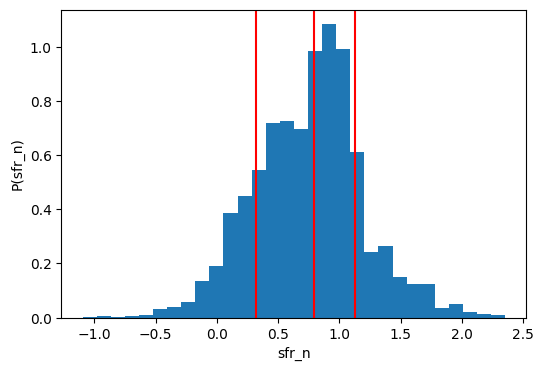

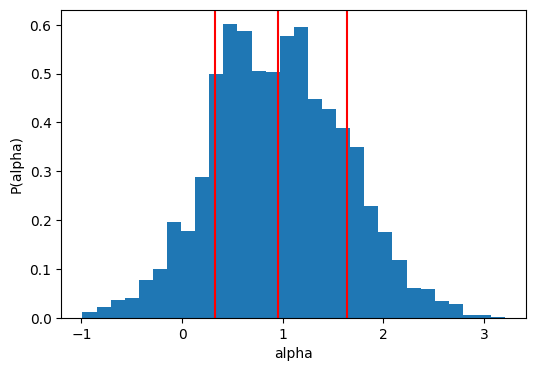

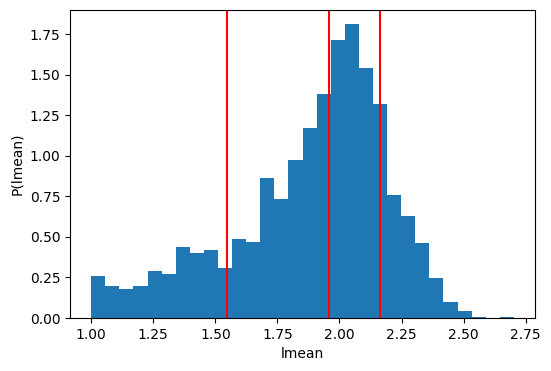

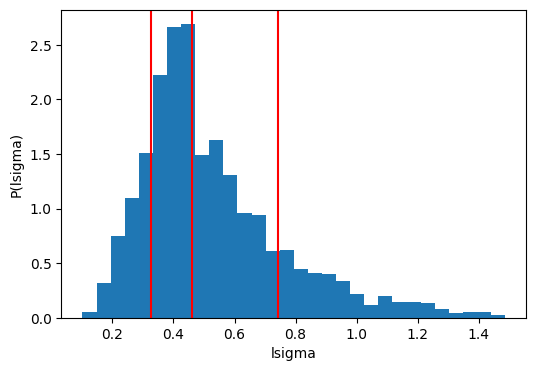

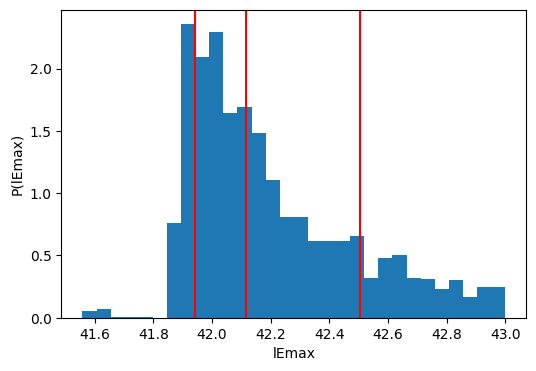

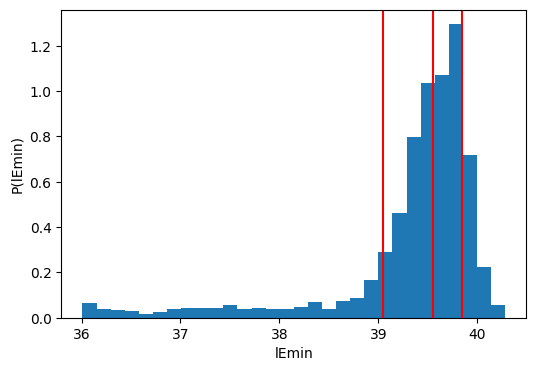

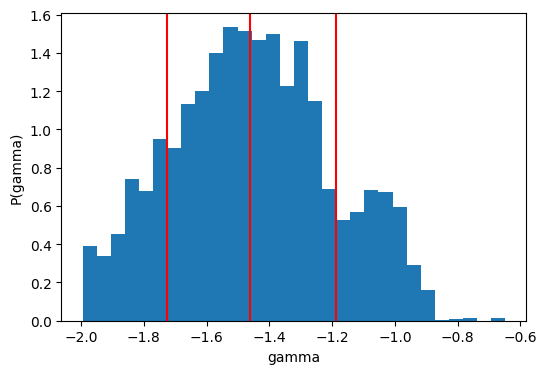

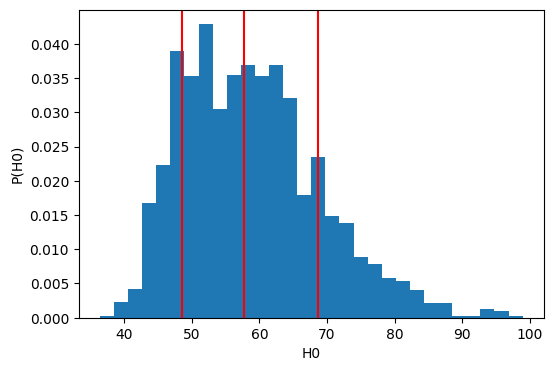

In [56]:
nBins = 30
win_len = int(nBins/10)
CL = 0.68

best_fit = {}

for i in range(len(labels)):
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(1,1,1)
    hist, bin_edges, _ = ax.hist(final_sample[:,i], bins=nBins, density=True)
    bin_width = bin_edges[1] - bin_edges[0]
    bins = -np.diff(bin_edges)/2.0 + bin_edges[1:]

    ax.set_xlabel(labels[i])
    ax.set_ylabel("P("+labels[i]+")")

    # Use mode ordered
    # ordered_idxs = np.argsort(hist)

    # sum = hist[ordered_idxs[0]] * bin_width
    # j = 1
    # while(sum < 1-CL):
    #     sum += hist[ordered_idxs[j]] * bin_width
    #     j = j+1

    # best = bins[ordered_idxs[-1]]
    # lower = bins[np.min(ordered_idxs[j:])]
    # upper = bins[np.max(ordered_idxs[j:])]

    # Use median
    best = np.quantile(final_sample[:,i], 0.5)
    best = bins[np.argmax(hist)]
    lower = np.quantile(final_sample[:,i], 0.16)
    upper = np.quantile(final_sample[:,i], 0.84)

    best_fit[labels[i]] = best
    u_lower = best - lower
    u_upper = upper - best
    ax.axvline(lower, color='r')
    ax.axvline(best, color='r')
    ax.axvline(upper, color='r')
    # print(labels[i] + ": " + str(best) + " (-" + str(u_lower) + "/+" + str(u_upper) + ")")
    print(rf'{labels[i]}: {best} (-{u_lower}/+{u_upper})')

print(best_fit)

In [57]:
import scipy.stats as st

In [58]:
# nsamps = np.linspace(3, np.log10(final_sample.shape[0]/10), 30)
# nsamps = [int(10**x) for x in nsamps]
# print("Number of samps: " + str(nsamps))

# for i in range(len(labels)):
#     # nsamps = []
#     std = []
#     for j in range(len(nsamps)):
#         best = []
#         nruns = int(final_sample.shape[0] / nsamps[j])
#         for k in range(nruns):
#             # best.append(np.quantile(final_sample[nsamps[j]*k:nsamps[j]*(k+1),i], 0.5))
#             step = int(final_sample.shape[0]/nsamps[j])
#             best.append(np.quantile(final_sample[k::step,i], 0.5))
#         std.append(np.std(best))

#     # print(labels[i] + ": " + str(std))

#     line = st.linregress(np.log10(nsamps),np.log10(std))
#     x = np.linspace(nsamps[0], nsamps[-1], 50)
#     y = 1/np.sqrt(x)
#     y = y / y[0] * std[0]
#     y = 10**(line.slope*np.log10(x) + line.intercept)
#     # print(line.slope)
#     print(labels[i] + ": " + str(10**(line.slope*np.log10(final_sample.shape[0]) + line.intercept)))
#     print(str(line.slope))
#     fig = plt.figure(figsize=(6,4))
#     ax = fig.add_subplot(1,1,1)

#     ax.plot(nsamps, std)
#     ax.loglog(x,y)
#     ax.set_xlabel("Number of samples")
#     ax.set_ylabel("Standard deviation")
#     ax.set_title(labels[i])

In [59]:
from zdm import survey
from zdm import cosmology as cos
from zdm import loading as loading
from zdm.misc_functions import *
import zdm.iteration as it
from zdm.MCMC import calc_log_posterior
from astropy.cosmology import Planck18

/fred/oz002/jhoffmann/FRB_library/zdm/.zdm_env/lib64/python3.9/site-packages/FRB-0.1.dev0-py3.9.egg/frb/halos/hmf.py:51: UserWarning: hmf_emulator not imported.  Hope you are not intending to use the hmf.py module..
  warnings.warn("hmf_emulator not imported.  Hope you are not intending to use the hmf.py module..")


In [60]:
s_names = [
    # "FAST2",
    # "FAST2_old"
    "DSA",
    "FAST", 
    "CRAFT_class_I_and_II", 
    "private_CRAFT_ICS_892_14", 
    "private_CRAFT_ICS_1300_14", 
    "private_CRAFT_ICS_1632_14", 
    "parkes_mb_class_I_and_II"
]
# rs_names = ["CHIME/CHIME_decbin_0_of_6",
#             "CHIME/CHIME_decbin_1_of_6",
#             "CHIME/CHIME_decbin_2_of_6",
#             "CHIME/CHIME_decbin_3_of_6",
#             "CHIME/CHIME_decbin_4_of_6",
#             "CHIME/CHIME_decbin_5_of_6"]
rs_names = []

state = parameters.State()
state.set_astropy_cosmo(Planck18) 
state.update_params(best_fit)
# state.update_param('luminosity_function', 2)
# state.update_param('alpha_method', 0)
# state.update_param('sfr_n', 1.36)
state.update_param('alpha', 1.5)
# state.update_param('lmean', 1.97)
# state.update_param('lsigma', 0.92)
# state.update_param('lEmax', 41.3)
# state.update_param('gamma', -0.63)
# state.update_param('H0', 70.0)
# state.update_param('DMhalo', 50.0)

if len(s_names) != 0:
    surveys, grids = loading.surveys_and_grids(survey_names = s_names, init_state=state, repeaters=False, nz=500, ndm=1400)
else:
    surveys = []
    grids = []

if len(rs_names) != 0:
    rep_surveys, rep_grids = loading.surveys_and_grids(survey_names = rs_names, init_state=state, repeaters=True, nz=500, ndm=1400)
    for s,g in zip(rep_surveys, rep_grids):
        surveys.append(s)
        grids.append(g)

Loading survey: DSA
Loading survey: DSA from DSA.ecsv
Loaded FRB info
FRB survey sucessfully initialised with  25  FRBs starting from 0
Ignoring redshifts with DMEG > 183.4312933794498
Loading survey: FAST
Loading survey: FAST from FAST.ecsv
Loaded FRB info
FRB survey sucessfully initialised with  9  FRBs starting from 0
Loading survey: CRAFT_class_I_and_II
Loading survey: CRAFT_class_I_and_II from CRAFT_class_I_and_II.ecsv
Loaded FRB info
FRB survey sucessfully initialised with  26  FRBs starting from 0
Loading survey: private_CRAFT_ICS_892_14
Loading survey: private_CRAFT_ICS_892_14 from private_CRAFT_ICS_892_14.ecsv
Loaded FRB info
FRB survey sucessfully initialised with  12  FRBs starting from 0
Loading survey: private_CRAFT_ICS_1300_14
Loading survey: private_CRAFT_ICS_1300_14 from private_CRAFT_ICS_1300_14.ecsv
Loaded FRB info
FRB survey sucessfully initialised with  15  FRBs starting from 0
Loading survey: private_CRAFT_ICS_1632_14
Loading survey: private_CRAFT_ICS_1632_14 from 

KeyboardInterrupt: 

DSA - expected, observed: 0.0, 0
FAST - expected, observed: 10.667620324727546, 9
CRAFT_class_I_and_II - expected, observed: 12.247732478097923, 20
private_CRAFT_ICS_892_14 - expected, observed: 20.51103102499614, 11
private_CRAFT_ICS_1300_14 - expected, observed: 8.986527948675947, 5
private_CRAFT_ICS_1632_14 - expected, observed: 1.1857355008392823, 1
parkes_mb_class_I_and_II - expected, observed: 6.435561422491906, 12


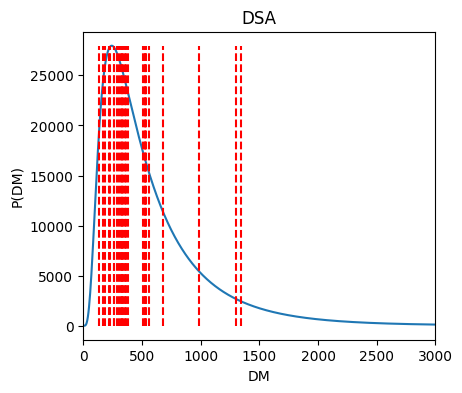

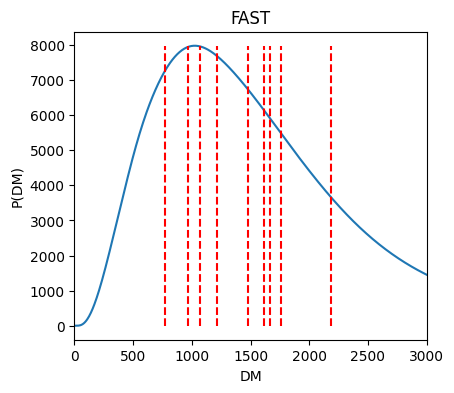

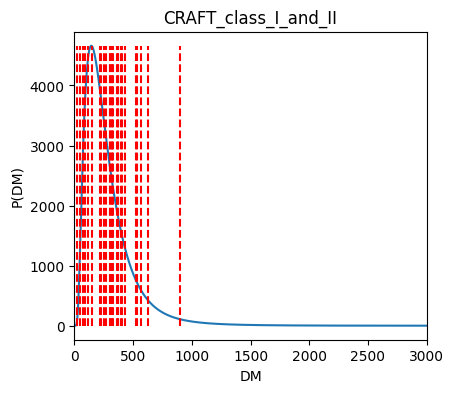

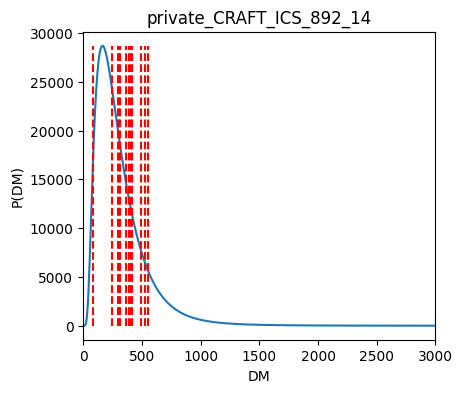

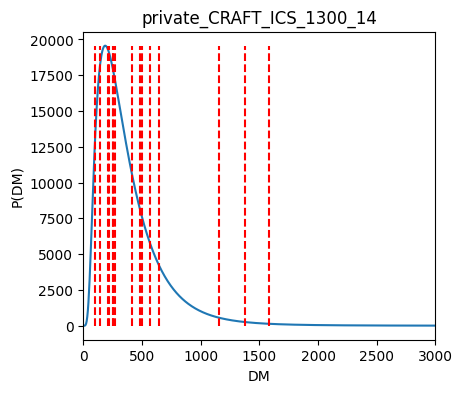

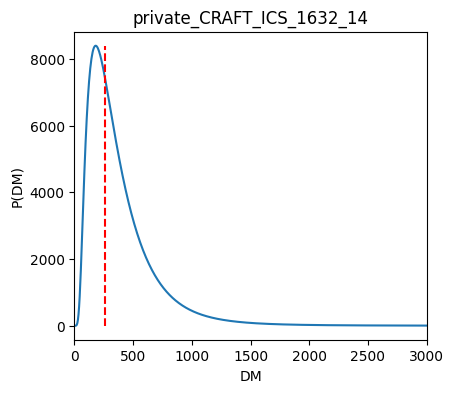

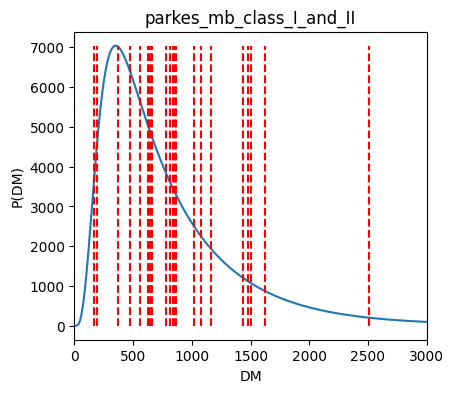

In [ ]:
newC, llc = it.minimise_const_only(None, grids, surveys)
llsum = 0
for s,g in zip(surveys, grids):

    g.state.FRBdemo.lC = newC
    
    # Calc pdm
    rates=g.rates
    dmvals=g.dmvals
    pdm=np.sum(rates,axis=0)

    # # Calc psnr
    # min = s.SNRTHRESHs[0]
    # max = np.max(s.SNRs)
    # snrs = np.linspace(min,max, 50)
    # psnr = get_psnr(snrs, s, g)
    
    # Plot pdm + snr
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(1,2,1)
    ax.set_title(s.name)
    ax.set_xlabel("DM")
    ax.set_ylabel("P(DM)")
    ax.set_xlim(xmax=3000)
    ax.plot(dmvals, pdm)
    ax.vlines(s.DMEGs, np.zeros(len(s.DMs)), np.max(pdm)*np.ones(len(s.DMs)), ls='--', colors='r')
    
    # ax = fig.add_subplot(1,2,2)
    # ax.set_xlabel("log SNR")
    # ax.set_ylabel("log P(SNR)")
    # ax.plot(np.log10(snrs), np.log10(psnr))
    # ax.vlines(np.log10(s.SNRs), np.min(np.log10(psnr))*np.ones(len(s.SNRs)), np.max(np.log10(psnr))*np.ones(len(s.SNRs)), ls='--', colors='r')

    # Get expected and observed
    expected=it.CalculateIntegral(g.rates,s)
    expected *= 10**g.state.FRBdemo.lC
    observed=s.NORM_FRB

    print(s.name + " - expected, observed: " + str(expected) + ", " + str(observed))

    llsum += it.get_log_likelihood(g,s,Pn=True)


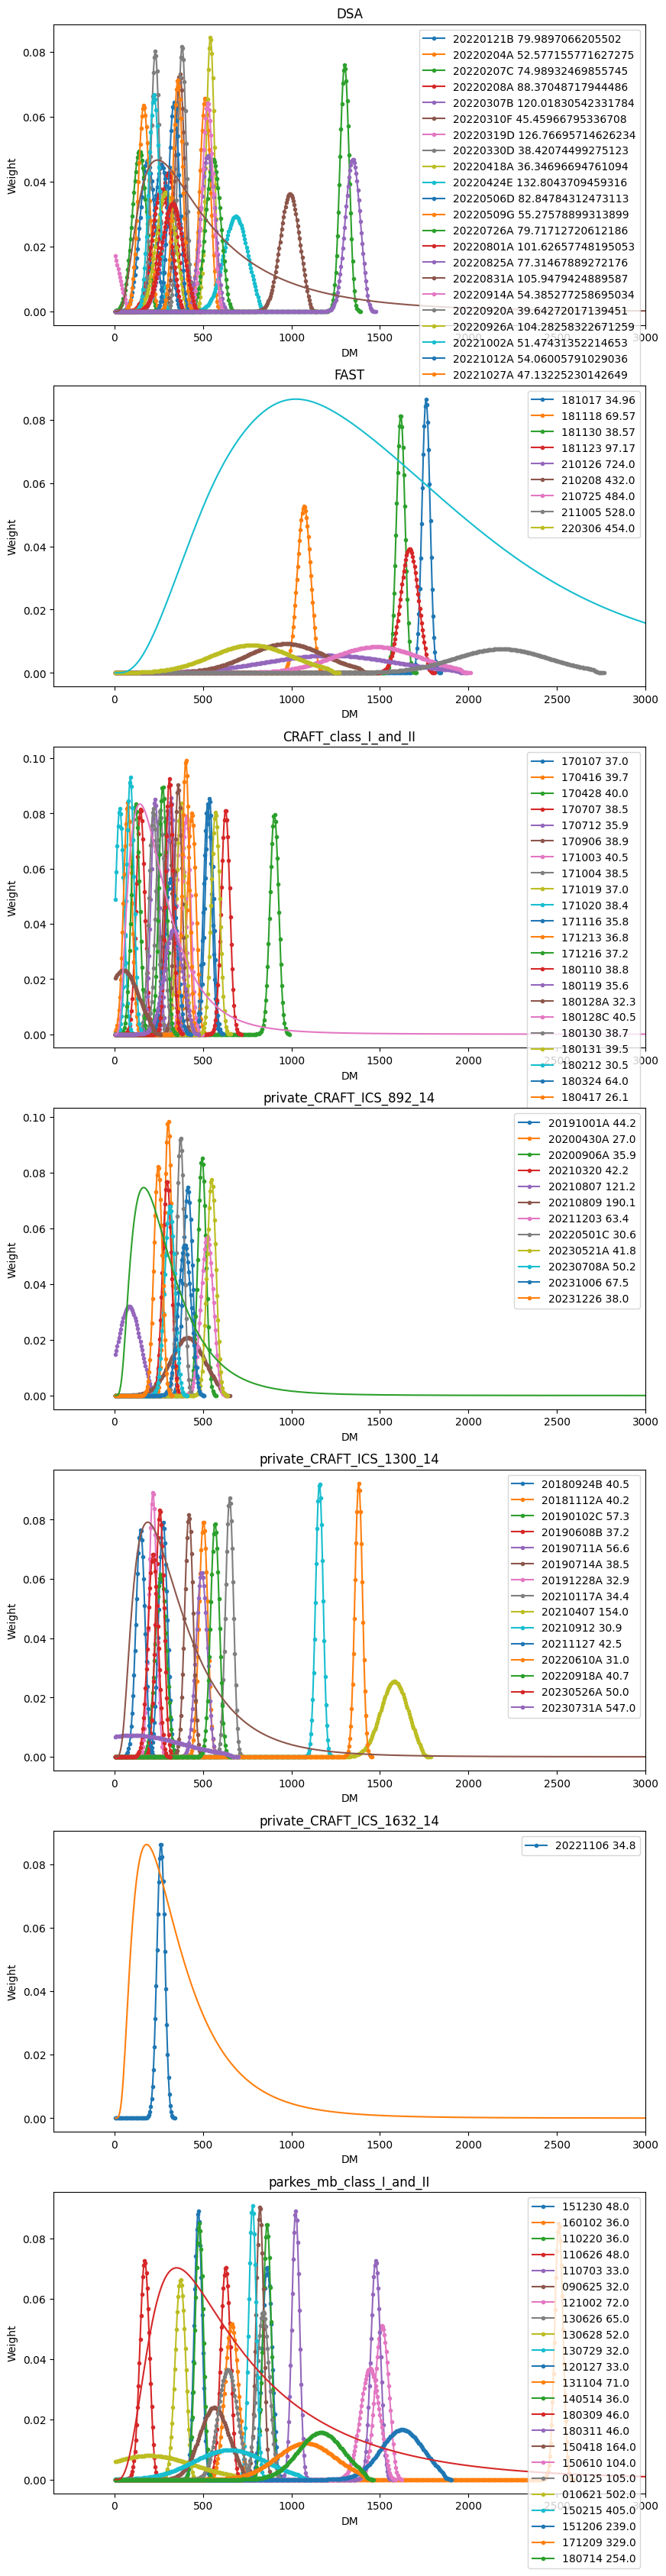

In [ ]:
uDMGs = 0.5
# DMhalo = 100.0

fig = plt.figure(figsize=(10,6*len(s_names)))

for j,(s,g) in enumerate(zip(surveys, grids)):
    ax = fig.add_subplot(len(surveys),1,j+1)
    plt.title(s.name)
    ax.set_xlabel('DM')
    ax.set_ylabel('Weight')

    # s.DMhalo = DMhalo
    # s.init_DMEG(DMhalo)

    dmvals=g.dmvals
    DMobs=s.DMEGs

    dm_weights, iweights = it.calc_DMG_weights(DMobs, s.DMhalo, s.DMGs, uDMGs, dmvals)

    pdm = np.sum(g.rates, axis=0)
    pdm = pdm / np.max(pdm) * np.max(dm_weights[0])

    for i in range(len(DMobs)):
        ax.plot(dmvals[iweights[i]], dm_weights[i], '.-', label=s.frbs["TNS"][i] + " " + str(s.DMGs[i]))

    ax.plot(dmvals, pdm) # Upper limit is not correct because grid has not been updated so efficiencies have not been recalc'd
    ax.set_xlim(right=3000)
    ax.legend()
    